# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [44]:
import pandas as pd
import numpy as np
import sqlite3
import pickle
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/cristine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/cristine/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
connection = sqlite3.connect('InsertDatabaseName.db') 
df = pd.read_sql_query("SELECT * FROM data_table", connection)
cat_df = pd.read_sql_query("SELECT * FROM unique_categories", connection)
connection.close()

In [10]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X = df['message']
Y = df.iloc[:, 4:]

X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [42]:
dist_calues = dict()
for column in Y.columns.tolist():
    dist_calues[column] = (df[column] == 1).sum()

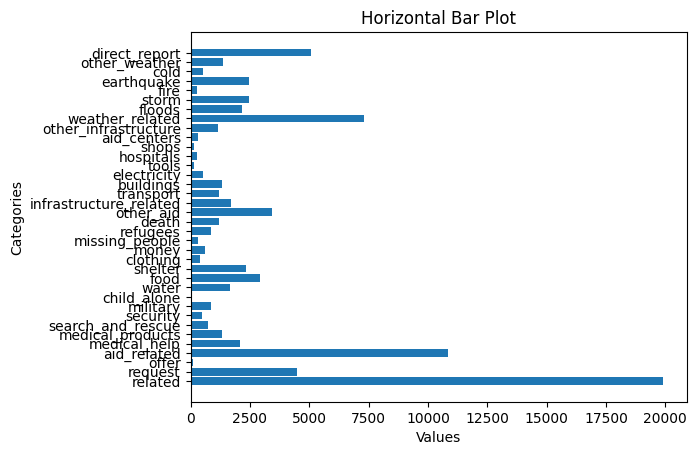

In [48]:
categories = list(dist_calues.keys())
values = list(dist_calues.values())

# Create horizontal bar plot
plt.barh(categories, values)

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Categories')
plt.title('Horizontal Bar Plot')

# Show plot
plt.show()

### 2. Write a tokenization function to process your text data

In [8]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [13]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('multi_clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=300)))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [16]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7e3fe9890160>)),
                ('tfidf', TfidfTransformer()),
                ('multi_clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [17]:
y_pred = pipeline.predict(X_test)

In [23]:
labels = np.unique(y_pred)
accuracy = (y_pred == y_test).mean()

print("Labels:", labels)
print("Accuracy:", accuracy)

Labels: [0 1 2]
Accuracy: related                   0.796308
request                   0.894416
offer                     0.996186
aid_related               0.776625
medical_help              0.919133
medical_products          0.947360
search_and_rescue         0.971620
security                  0.981538
military                  0.970095
child_alone               1.000000
water                     0.948734
food                      0.934544
shelter                   0.924779
clothing                  0.985352
money                     0.973909
missing_people            0.986726
refugees                  0.968264
death                     0.956668
other_aid                 0.872902
infrastructure_related    0.934849
transport                 0.956515
buildings                 0.948123
electricity               0.981996
tools                     0.994049
hospitals                 0.987946
shops                     0.994965
aid_centers               0.988557
other_infrastructure      0.9

### 6. Improve your model
Use grid search to find better parameters. 

In [31]:
parameters = {
    'vect__ngram_range': ((1, 1), (1, 2)),
    'multi_clf__estimator__n_estimators': [100, 200, 300],
    'multi_clf__estimator__max_depth': [None, 10, 20],
    'multi_clf__estimator__min_samples_split': [2, 5, 10],
}

model = GridSearchCV(pipeline, param_grid=parameters)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [32]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [33]:
model.best_params_

{'multi_clf__estimator__max_depth': None,
 'multi_clf__estimator__min_samples_split': 2,
 'multi_clf__estimator__n_estimators': 300,
 'vect__ngram_range': (1, 2)}

In [34]:
labels = np.unique(y_pred)
accuracy = (y_pred == y_test).mean()

print("Labels:", labels)
print("Accuracy:", accuracy)

Labels: [0 1 2]
Accuracy: related                   0.793256
request                   0.901587
offer                     0.996186
aid_related               0.778303
medical_help              0.918065
medical_products          0.950565
search_and_rescue         0.972383
security                  0.981538
military                  0.969637
child_alone               1.000000
water                     0.955905
food                      0.943393
shelter                   0.931645
clothing                  0.985658
money                     0.974062
missing_people            0.986726
refugees                  0.969027
death                     0.958499
other_aid                 0.872292
infrastructure_related    0.935154
transport                 0.955752
buildings                 0.948428
electricity               0.981691
tools                     0.994049
hospitals                 0.988099
shops                     0.994965
aid_centers               0.988404
other_infrastructure      0.9

### 9. Export your model as a pickle file

In [37]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 10. Import your model from the pickle file

In [9]:
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)